In [3]:
import numpy as np
from skimage import feature
import pickle
from sklearn.svm import SVC
import random

SEED=444
random.seed(SEED) # Use this to get repeateable randomisation

class features_class:
    def __init__(self,X,y):
        self.X = X
        self.y = y
def apply_features_filter(given_X):
    temp_X = np.delete(given_X,[8,26,52],1)
    return temp_X

# Load training feature files
dataset_base_path = "/scratch/git/LBP/data/small_dataset/out"
with open (dataset_base_path +"/features_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-cmask-thick-6.pickle",'rb') as f:
    my_features_cmask = pickle.load(f)
    print "Loaded %d images x %d features " %(len(my_features_cmask.X), len(my_features_cmask.X[1]))
    
with open (dataset_base_path +"/features_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-pass.pickle",'rb') as f:
    my_features_pass = pickle.load(f)
    print "Loaded %d images x %d features " %(len(my_features_pass.X), len(my_features_pass.X[1]))
    
with open (dataset_base_path +"/features_FE-lbp-rui-r1-n8-r2-n16-r3-n24_PP-comb-thick-6-k-0.2.pickle",'rb') as f:
    my_features_comb = pickle.load(f)
    print "Loaded %d images x %d features " %(len(my_features_comb.X), len(my_features_comb.X[1]))


# Perform a simple check for the cmask
X = np.asarray(my_features_cmask.X).copy()
#X = np.concatenate((X,my_features_2.X),axis=0)
X = X+ np.asarray(my_features_pass.X).copy()*0.2

# filter features
X= apply_features_filter(X)
my_features_pass.X  = apply_features_filter(my_features_pass.X)
my_features_cmask.X = apply_features_filter(my_features_cmask.X)
my_features_comb.X = apply_features_filter(my_features_comb.X)

y = np.asarray(my_features_cmask.y).copy()
#y = np.concatenate((y,my_features_2.y),axis=0)
print "Pass    : ", len(my_features_pass.X), ' x ', len(my_features_pass.X[0])
print "Cmask   : ", len(my_features_cmask.X), ' x ', len(my_features_cmask.X[0])
print "Combined: ", len(X), ' x ', len(X[0])




Loaded 80 images x 54 features 
Loaded 80 images x 54 features 
Loaded 80 images x 54 features 
Pass    :  80  x  51
Cmask   :  80  x  51
Combined:  80  x  51


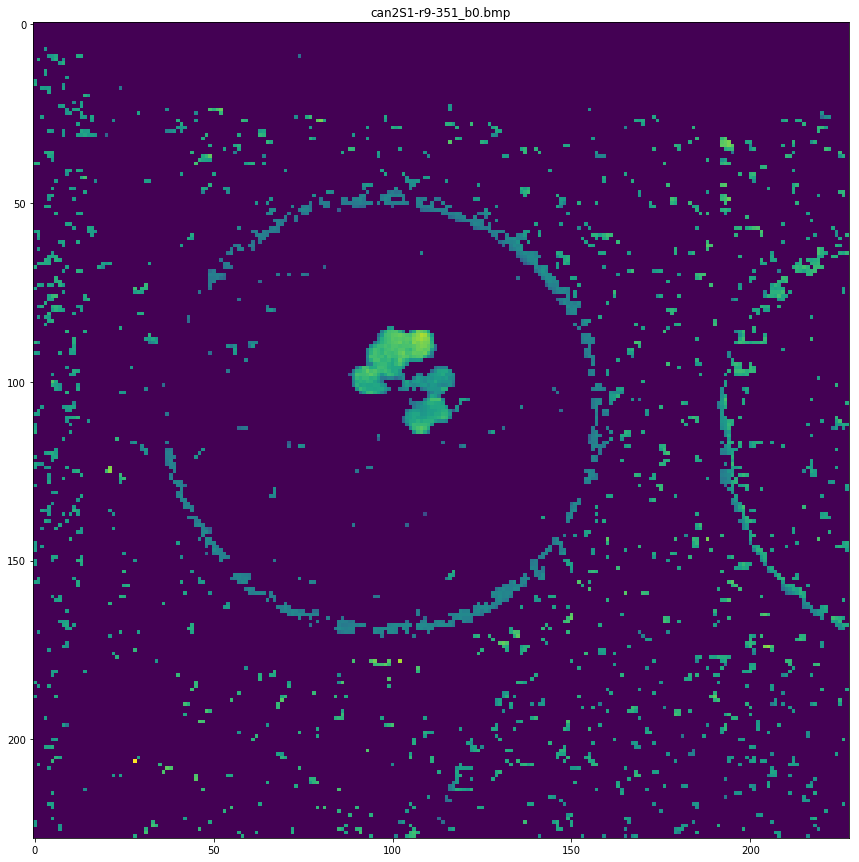

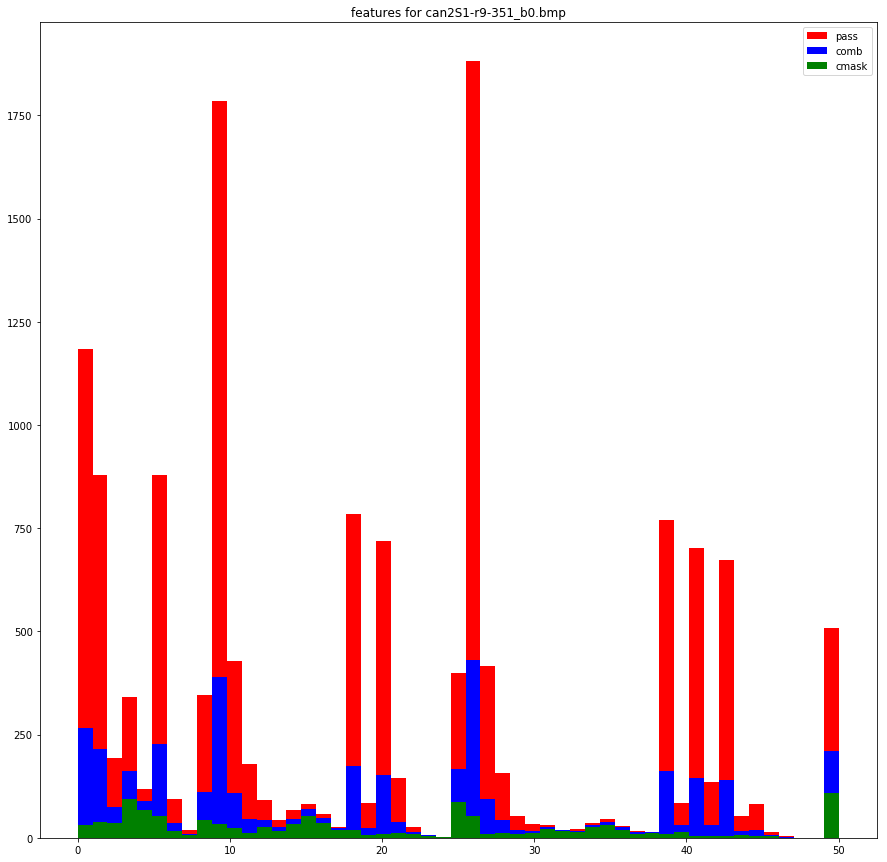

In [10]:
from matplotlib import pyplot as plt
import cv2

img_no = 0; # image to select from features set to display
f= my_features_pass
img_path = f.base_path + '/' + f.y[img_no] + '/' + f.img_names[img_no]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.title(f.img_names[img_no])
plt.show()

plt.rcParams['figure.figsize'] = (15,15)
n_features=len(my_features_pass.X[img_no])
plt.hist(range(n_features), bins=n_features, weights=my_features_pass.X[0],color='r')
plt.hist(range(n_features), bins=n_features, weights=my_features_comb.X[0],color='b')
plt.hist(range(n_features), bins=n_features, weights=my_features_cmask.X[0],color='g')
plt.legend(['pass','comb','cmask'])
plt.title('features for %s' %(my_features_pass.img_names[img_no]))
#plt.plot(my_features_cmask.X[0],'b')
plt.show()
